## Least-squares fits

A cost function for a general weighted least-squares fit (aka chi-square fit) is also included. In statistics this is called non-linear regression.

In this case you need to provide a model that predicts the y-values as a function of the x-values and the parameters. The fit needs estimates of the y-errors. If those are wrong, the fit may be biased. If your data has errors on the x-values as well, checkout the tutorial about automatic differentiation, which includes an application of that to such fits.

In [1]:
using Minuit2
using Plots

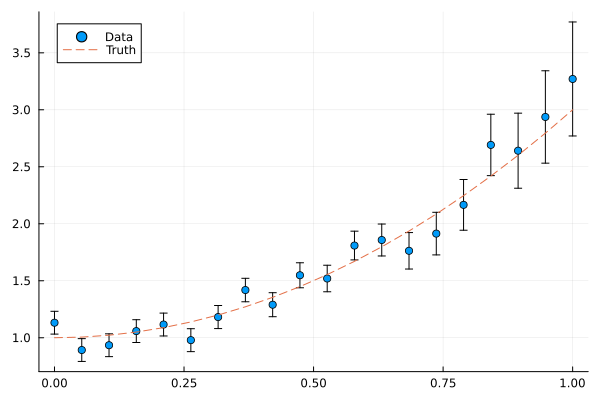

In [2]:
# Define the model
model(x, a, b) = a + b * x^2

# Define the data and truth
truth = 1, 2
x = range(0, 1., 20) |> collect
yt = model.(x, truth...)
ye = 0.4 .* x.^5 .+ 0.1
y = yt + ye .* randn(length(x))

# Plot with error bars
plot(x, y, yerr=ye, seriestype=:scatter, label="Data")
plot!(x, yt, label="Truth", linestyle=:dash)

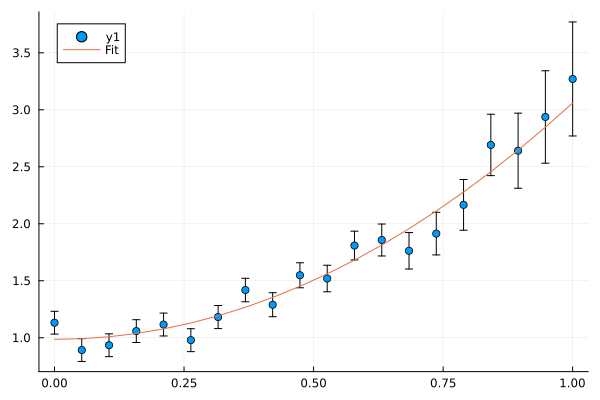

In [3]:
c = LeastSquares(x, y, ye, model)
m1 = Minuit(c, a=0, b=0)
migrad!(m1)
visualize(m1)

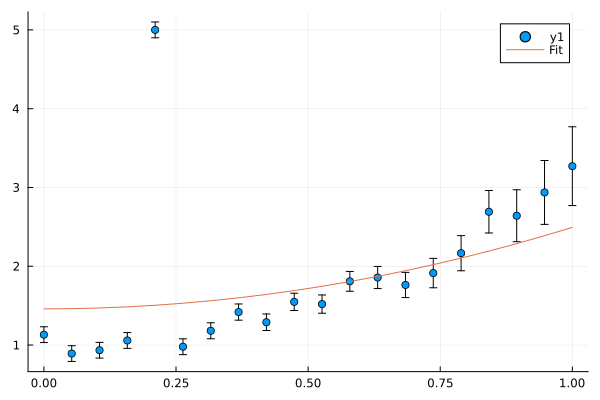

In [7]:
m1.cost.y[5] = 5.0
migrad!(m1)
visualize(m1)

In [8]:
m1.parameters

┌───┬──────┬─────────┬─────────────┬────────┬────────┬────────┬────────┬────────
│   │ Name │ Value   │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed ⋯
├───┼──────┼─────────┼─────────────┼────────┼────────┼────────┼────────┼────────
│ 1 │ a    │ 1.45913 │ 0.0372301   │        │        │        │        │       ⋯
│ 2 │ b    │ 1.0348  │ 0.150494    │        │        │        │        │       ⋯
└───┴──────┴─────────┴─────────────┴────────┴────────┴────────┴────────┴────────
                                                                1 column omitted
